wavenet 원본 논문 [Wavenet](https://arxiv.org/abs/1711.10433)  

참고한 코드 [Wavenet Classifier](https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py)


### Next Steps
The next steps could be
- use more data to train
- include the country code (different countries draw different things, different ways)
- more complex models

### Model Parameters

모델에 사용되는 파라미터들의 집합

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
n_filters = 64
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

In [ ]:
!pip install np_utils

In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
base_dir = os.path.join('/content/drive/MyDrive/졸업작품')
test_path = os.path.join(base_dir, 'test_simplified.csv')

print(test_path)

file = pd.read_csv(test_path)
print(file)

/content/drive/MyDrive/졸업작품/test_simplified.csv
                  key_id countrycode  \
0       9000003627287624          DE   
1       9000010688666847          UA   
2       9000023642890129          BG   
3       9000038588854897          US   
4       9000052667981386          AR   
...                  ...         ...   
112194  9999946504414373          US   
112195  9999967586702768          MY   
112196  9999968529902445          US   
112197  9999969540362833          US   
112198  9999996442242305          RS   

                                                  drawing  
0       [[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25...  
1       [[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16...  
2       [[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ...  
3       [[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20...  
4       [[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,...  
...                                                   ...  
112194  [[[103, 67, 37, 10, 2, 0, 11, 24, 4

모델의 학습에 사용될 dataset을 만드는 코드

먼저 glob함수를 통해 디렉토리 내의 모든 csv데이터들의 경로를 가져온다.
그 후 하나씩 파일을 읽으며 drawing들을 full_df에 삽입하며 _stack_it 함수를 통해 string을 standard Nx3 stroke vector 형태로 변환하여 저장한다.

In [ ]:
from ast import literal_eval
path = os.path.join(base_dir, 'train_simplified', '*.csv')
ALL_TRAIN_PATHS = glob(path)
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)
     for i,(x,y) in enumerate(stroke_vec)
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1),
                         maxlen=STROKE_COUNT,
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5,
               start_row=0,
               max_rows=1000):
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)

    return full_df

# Reading and Parsing

train, test, validation 로 각각 dataset 나눔

In [ ]:
train_args = dict(samples=TRAIN_SAMPLES,
                  start_row=0,
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES,
                  start_row=train_args['max_rows']+1,
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES,
                 start_row=valid_args['max_rows']+train_args['max_rows']+1,
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 214 => airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feather, fence, finger, fire hydrant, fireplace, firetruck, fish

In [ ]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(160500, 196, 3)


# Stroke-based Classification

dataset의 stroke정보들을 정답 label과 함께 시각화함.

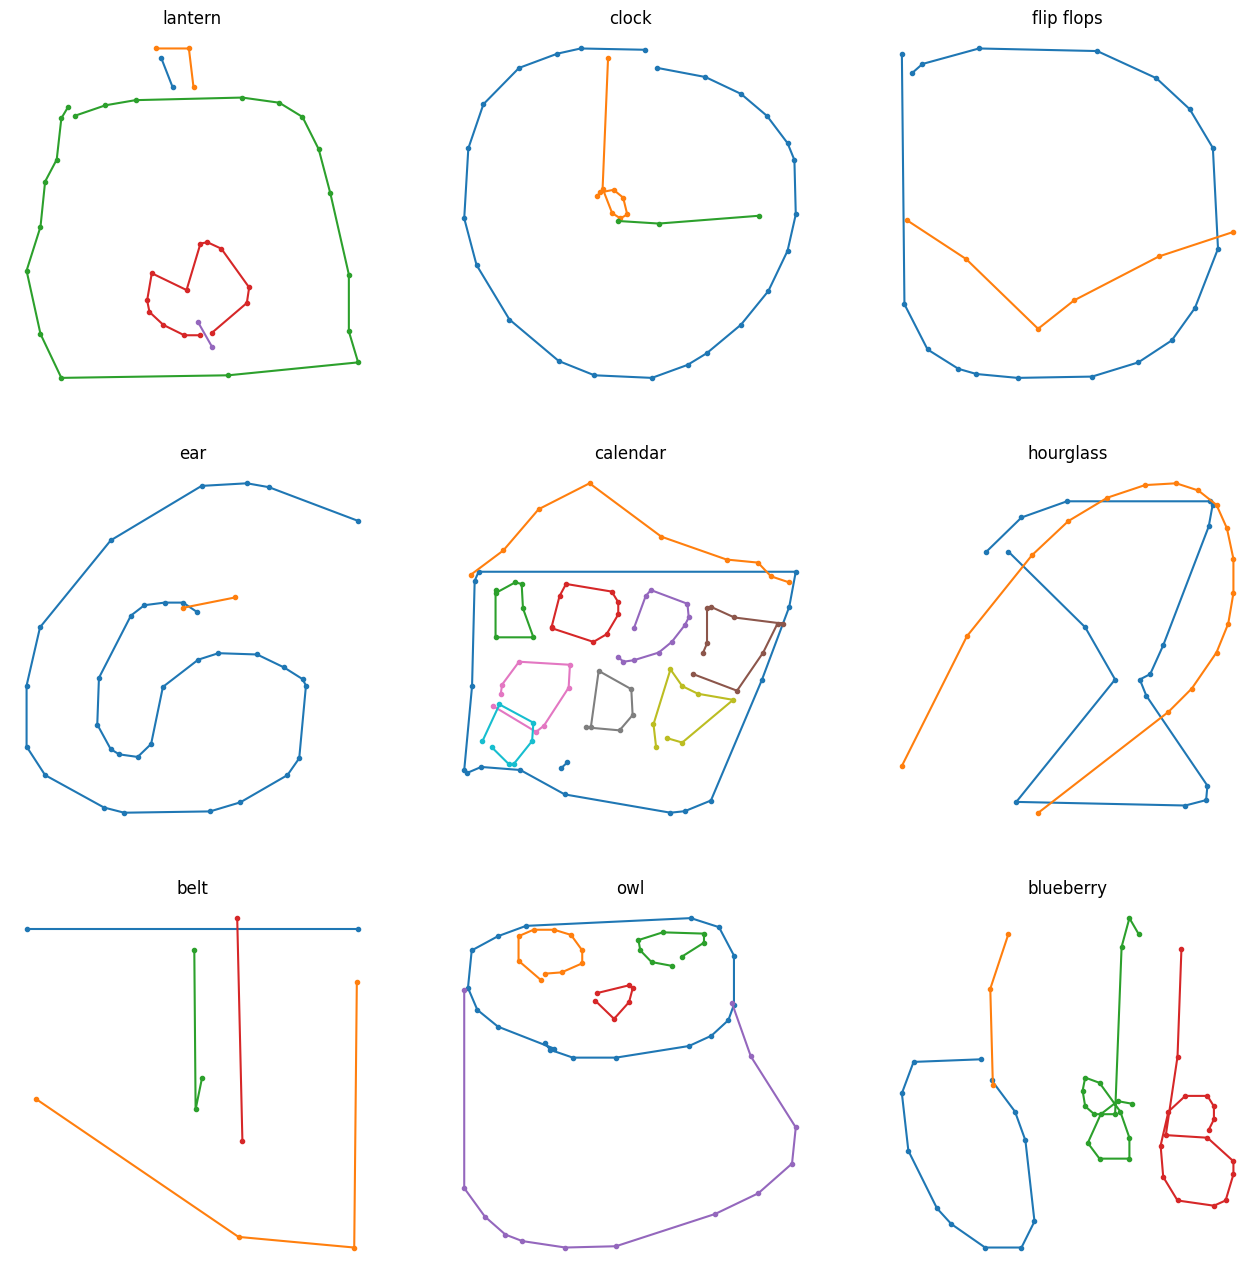

In [ ]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 4)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0],
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

# WaveNet to Parse Strokes

위의 논문에서 제안한 wavenet 모델을 구축함.

모델이 각각 어떤 layer들로 구성되는지, 각 layer의 output shape은 어떤 형태인지 나타냄

In [ ]:
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, Multiply, GlobalAveragePooling1D
from keras.models import Model
input_shape = train_X.shape[1:]
output_shape = train_y.shape[1:]
def residual_block(x, i):
    tanh_out = Conv1D(n_filters,
                      kernel_size,
                      dilation_rate = kernel_size**i,
                      padding='causal',
                      name='dilated_conv_%d_tanh' % (kernel_size ** i),
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters,
                      kernel_size,
                      dilation_rate = kernel_size**i,
                      padding='causal',
                      name='dilated_conv_%d_sigm' % (kernel_size ** i),
                      activation='sigmoid'
                      )(x)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip
x = Input(shape=input_shape, name='original_input')
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add(name='skip_connections')(skip_connections)
out = Activation('relu')(out)

out = Conv1D(n_filters, pool_size_1, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
out = AveragePooling1D(pool_size_1, padding='same', name='downsample_to_200Hz')(out)

out = Conv1D(n_filters, pool_size_2, padding='same', activation='relu', name='conv_500ms')(out)
out = Conv1D(output_shape[0], pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
out = AveragePooling1D(pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)
out = Conv1D(output_shape[0], (int) (input_shape[0] / (pool_size_1*pool_size_2)), padding='same', name='final_conv')(out)
out = GlobalAveragePooling1D(name='final_pooling')(out)
out = Activation(activation, name='final_activation')(out)

stroke_read_model = Model(x, out)
stroke_read_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy', top_3_accuracy])
stroke_read_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 original_input (InputLayer  [(None, 196, 3)]             0         []                            
 )                                                                                                
                                                                                                  
 dilated_conv_1 (Conv1D)     (None, 196, 64)              448       ['original_input[0][0]']      
                                                                                                  
 dilated_conv_2_tanh (Conv1  (None, 196, 64)              8256      ['dilated_conv_1[0][0]']      
 D)                                                                                               
                                                                                              

Keras의 콜백(callback)을 사용하여 모델 훈련 중에 다양한 동작을 수행하도록 설정함

**ModelCheckpoint**  
모델의 가중치를 저장하는 콜백. 특히, 검증 손실(val_loss)이 이전 최솟값보다 낮을 경우에만 가중치를 저장. 이를 통해 훈련 중에 최상의 성능을 보이는 모델의 가중치를 기록할 수 있다. 파일명은 'stroke_lstm_model_weights.best.hdf5'로 설정되며, 모델이 저장한 최적의 가중치는 weight_path에 저장된다.

**ReduceLROnPlateau**  
검증 손실(val_loss)이 향상되지 않을 경우(즉, 더 이상 학습이 진전되지 않을 때), 학습률을 감소시키는 콜백. 이를 통해 학습이 수렴하도록 도움을 줄 수 있다. 학습률 감소는 팩터(factor) 0.8을 기준으로 이루어지며, 10 에폭 동안 개선이 없을 경우에 적용된다.

**EarlyStopping**  
검증 손실(val_loss)이 더 이상 개선되지 않을 경우 훈련을 조기 중단하는 콜백. 최소 5 에폭의 인내 기간(patience)을 가지고 있다. 이는 과적합을 방지하고 효율적인 훈련을 위해 사용된다.



In [ ]:
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5) # probably needs to be more patient
callbacks_list = [checkpoint, early, reduceLROnPlat]

모델을 학습시킴

In [ ]:
from IPython.display import clear_output
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y),
                      batch_size = batch_size,
                      epochs = 5,
                      callbacks = callbacks_list)
clear_output()

Epoch 1/5


###Validation result

가장 좋은 결과를 낸 weight를 load해서 결과를 출력함.  
loss : 1.8150   
accuarcy : 0.5733  
top 3개의 결과에 대한 accuarcy : 0.7648

**For each words**  
각 단어에 대해서 각각 precision, recall, f1-score, support를 출력함.  
모든 단어에 대한 avg는 다음과 같다.  

avg precision : 0.59  
avg recall : 0.57  
avg f1-score : 0.57

In [ ]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

3/3 [==============================] - 5s 2s/step - loss: 1.8150 - accuracy: 0.5733 - top_3_accuracy: 0.7648
Accuracy: 57.3%, Top 3 Accuracy 76.5%


3/3 [==============================] - 2s 504ms/step
                  precision    recall  f1-score   support

        airplane       0.66      0.70      0.68        50
     alarm clock       0.63      0.52      0.57        50
       ambulance       0.42      0.56      0.48        50
           angel       0.57      0.62      0.60        50
animal migration       0.44      0.28      0.34        50
             ant       0.56      0.60      0.58        50
           anvil       0.65      0.44      0.52        50
           apple       0.70      0.94      0.80        50
             arm       0.53      0.52      0.53        50
       asparagus       0.67      0.60      0.63        50
             axe       0.57      0.48      0.52        50
        backpack       0.62      0.50      0.56        50
          banana       0.81      0.44      0.57        50
         bandage       0.62      0.60      0.61        50
            barn       0.46      0.56      0.50        50
        baseball  

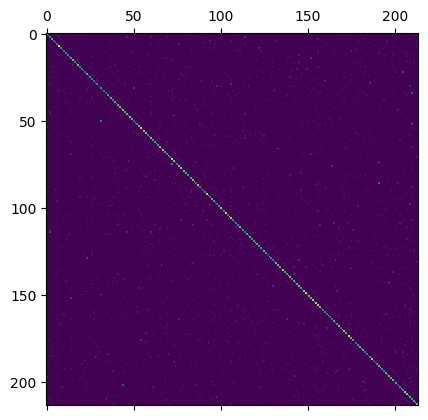

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = 4096)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat,
                            target_names = [x for x in word_encoder.classes_]))

# Reading Point by Point

테스트 데이터의 무작위 샘플에서 몇 가지 문자를 임의로 선택하여 시각화한다. 이 때, 선택된 문자 시퀀스의 일부 점들을 잘라내어 입력 데이터를 변형시키고, LSTM 모델을 사용하여 손글씨 문자를 예측한다. 각 subplot은 예측 결과를 시각화하며, 제목에는 실제 정답 및 모델의 예측 결과가 표시된다.

1/1 [==============================] - 0s 27ms/step


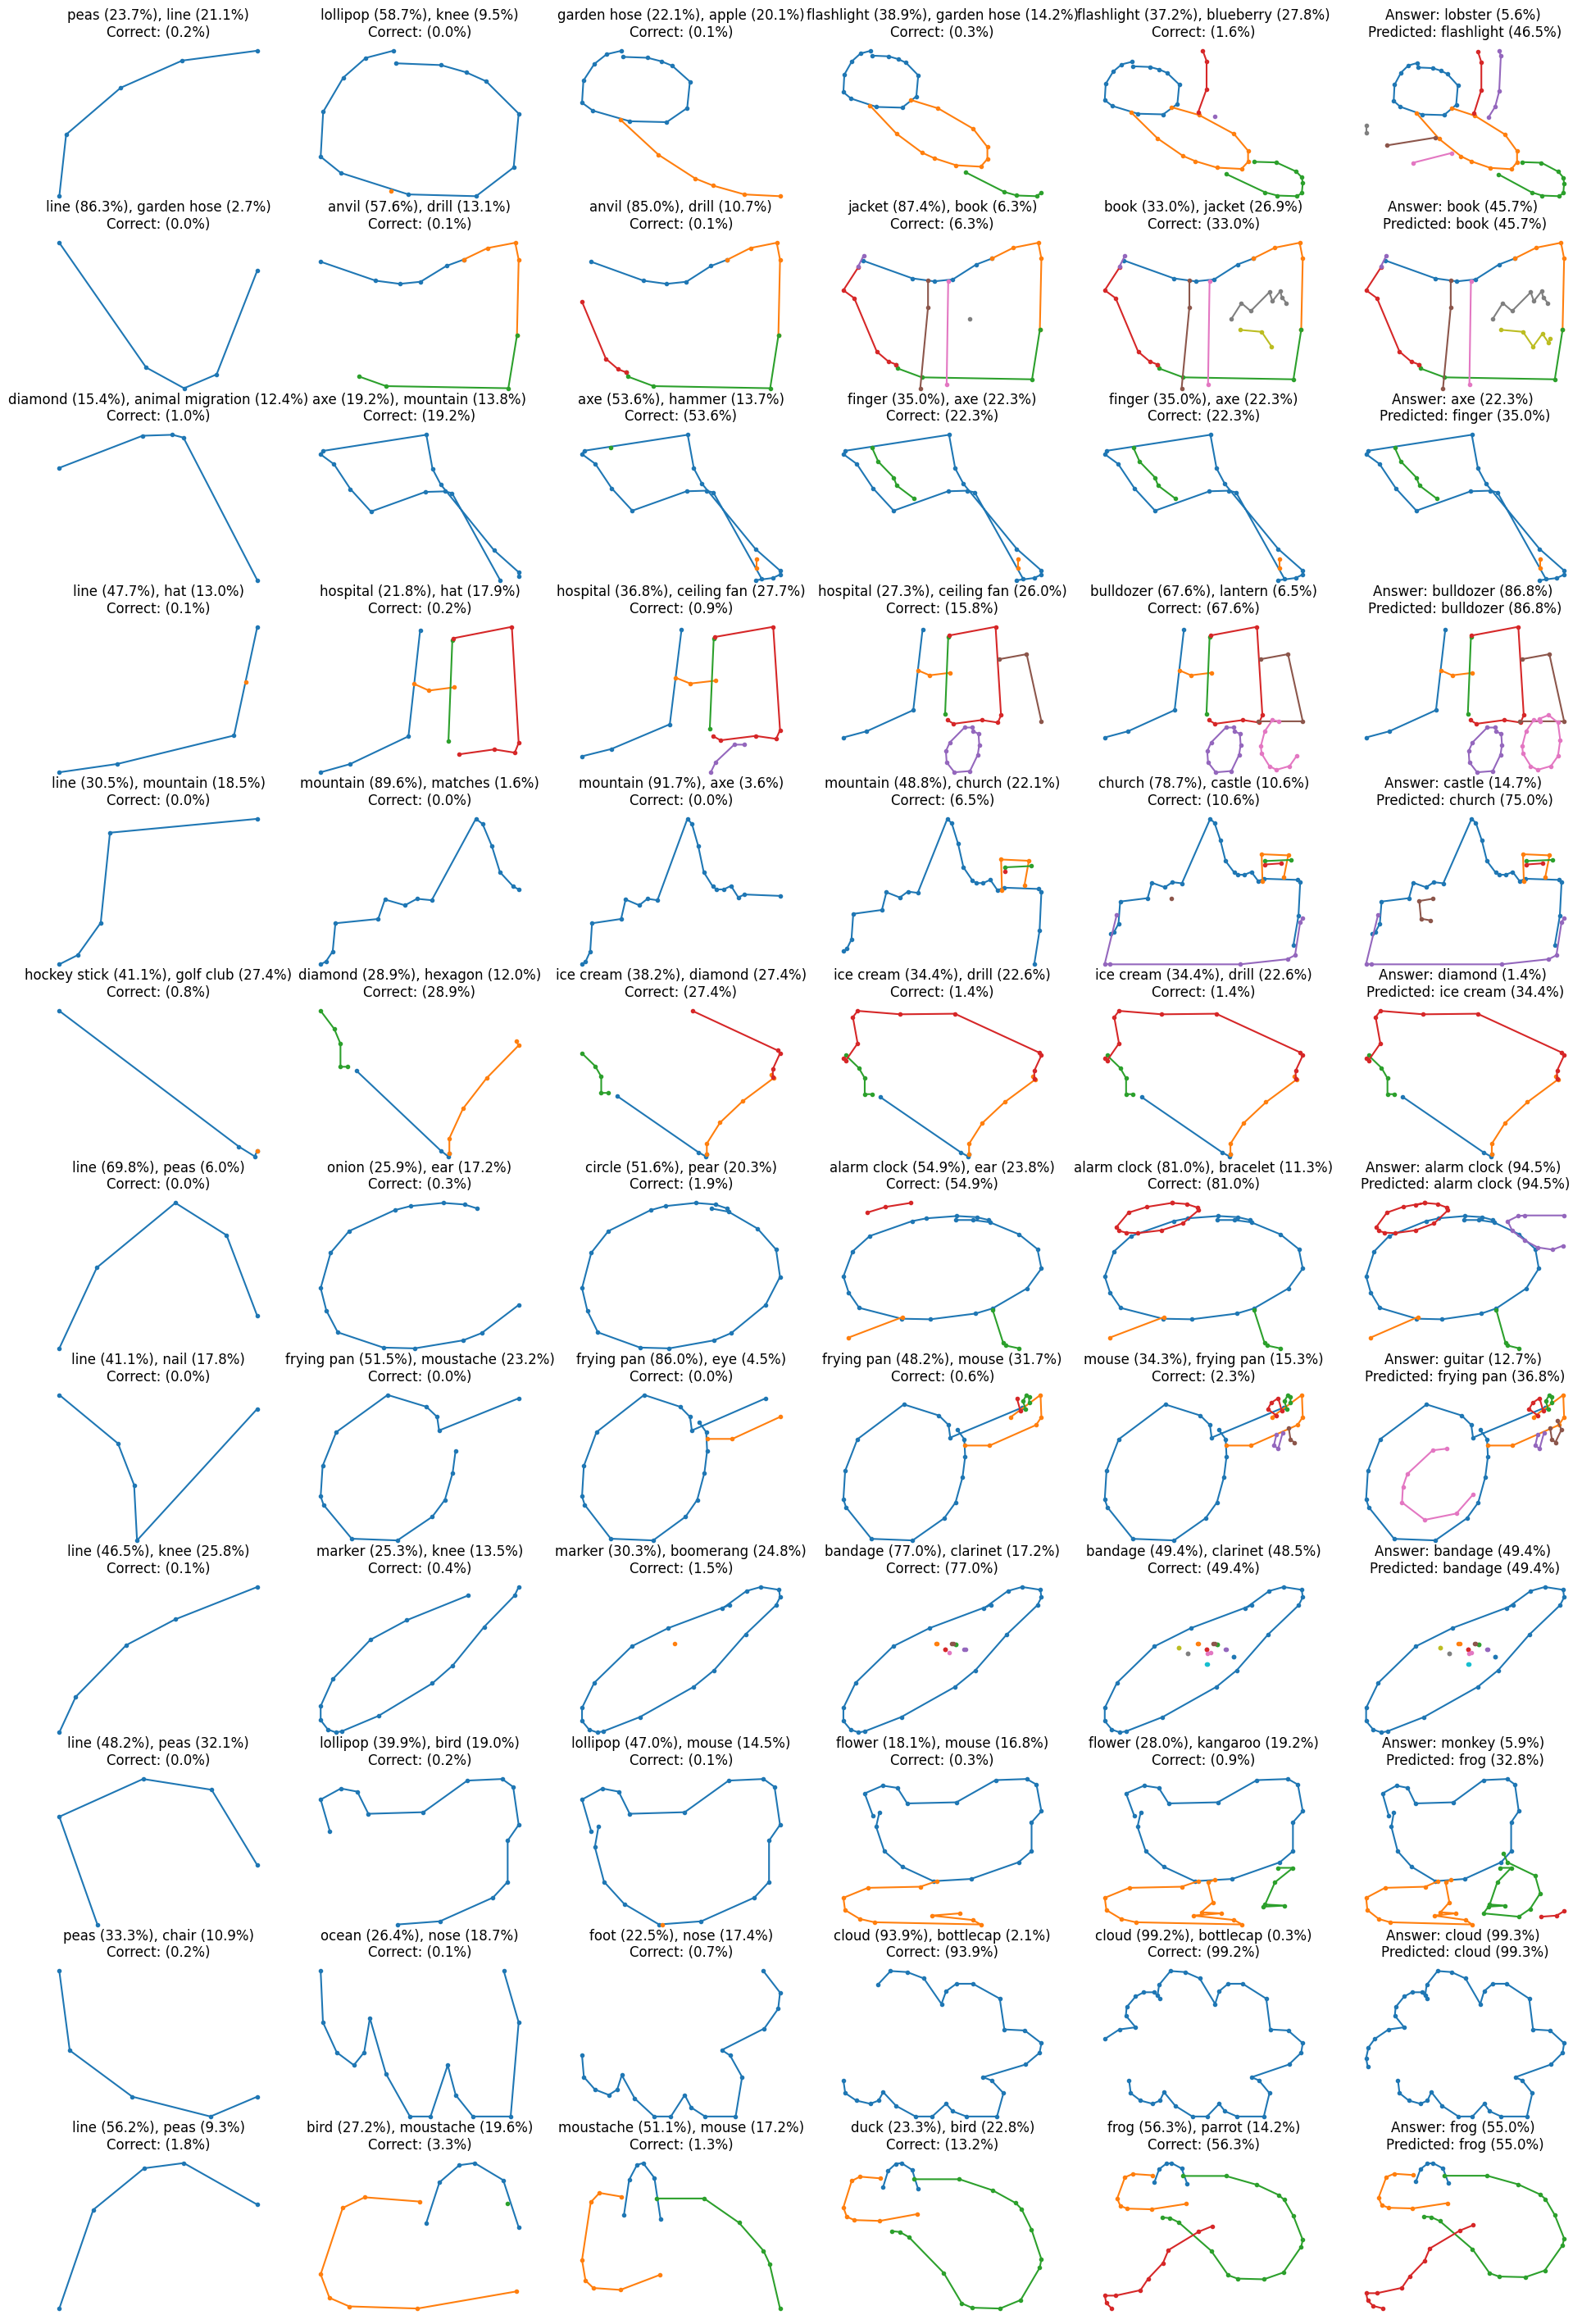

In [ ]:
points_to_use = [5, 15, 20, 30, 40, 50]
points_to_user = [108]
samples = 12
word_dex = lambda x: word_encoder.classes_[x]
rand_idxs = np.random.choice(range(test_X.shape[0]), size = samples)
fig, m_axs = plt.subplots(len(rand_idxs), len(points_to_use), figsize = (24, samples/8*24))
for c_id, c_axs in zip(rand_idxs, m_axs):
    res_idx = np.argmax(test_y[c_id])
    goal_cat = word_encoder.classes_[res_idx]

    for pt_idx, (pts, c_ax) in enumerate(zip(points_to_use, c_axs)):
        test_arr = test_X[c_id, :].copy()
        test_arr[pts:] = 0 # short sequences make CudnnLSTM crash, ugh
        stroke_pred = stroke_read_model.predict(np.expand_dims(test_arr,0))[0]
        top_10_idx = np.argsort(-1*stroke_pred)[:10]
        top_10_sum = np.sum(stroke_pred[top_10_idx])

        test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
        lab_idx = np.cumsum(test_arr[:,2]-1)
        for i in np.unique(lab_idx):
            c_ax.plot(test_arr[lab_idx==i,0],
                    np.max(test_arr[:,1])-test_arr[lab_idx==i,1], # flip y
                      '.-')
        c_ax.axis('off')
        if pt_idx == (len(points_to_use)-1):
            c_ax.set_title('Answer: %s (%2.1f%%) \nPredicted: %s (%2.1f%%)' % (goal_cat, 100*stroke_pred[res_idx]/top_10_sum, word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum))
        else:
            c_ax.set_title('%s (%2.1f%%), %s (%2.1f%%)\nCorrect: (%2.1f%%)' % (word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum,
                                                                 word_dex(top_10_idx[1]), 100*stroke_pred[top_10_idx[1]]/top_10_sum,
                                                                 100*stroke_pred[res_idx]/top_10_sum))

# Load sample test dataset

In [ ]:
sub_df = pd.read_csv(test_path)
sub_df['drawing'] = sub_df['drawing'].map(_stack_it)

In [ ]:
sub_vec = np.stack(sub_df['drawing'].values, 0)
sub_pred = stroke_read_model.predict(sub_vec, verbose=True, batch_size=4096)

28/28 [==============================] - 17s 613ms/step


# Show top 3 predictions on the dataset

In [ ]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in sub_pred]

In [ ]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

['firetruck hot_tub birthday_cake',
 'hockey_puck hamburger bottlecap',
 'camel castle hand']

sample test dataset의 top 3 prediction result를 각 drawing과 함께 시각화함

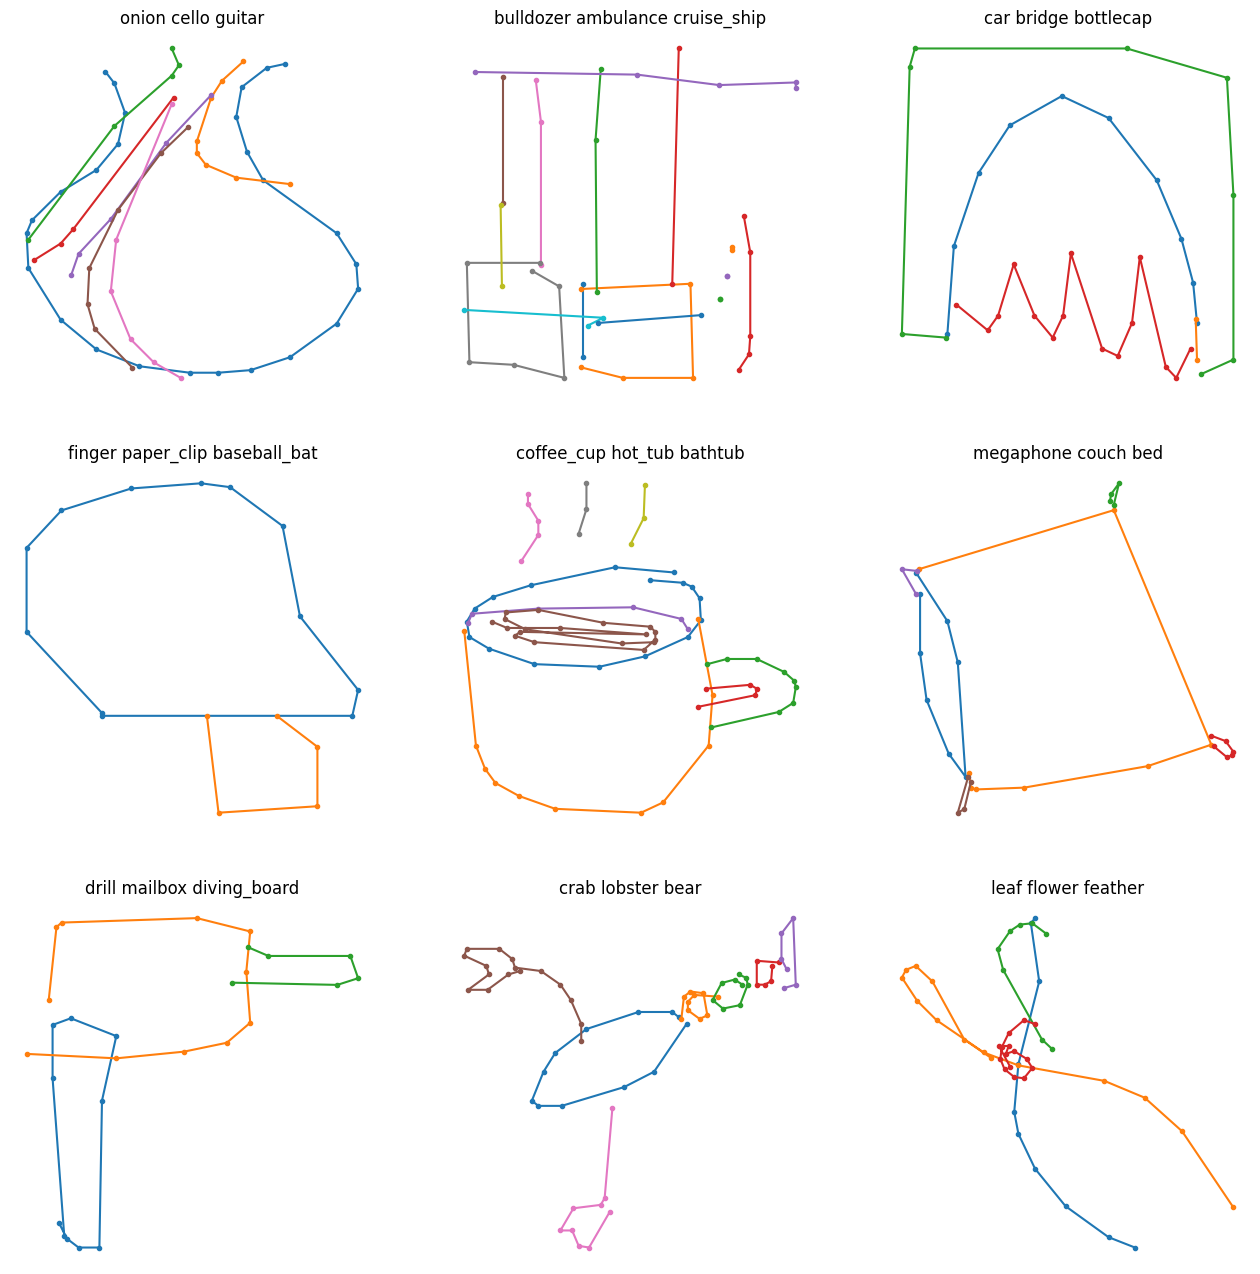

In [ ]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(sub_vec.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = sub_vec[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0],
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])